# Wavefront sensing with a Pyramid wavefront sensor

We will simulate a closed-loop adaptive optics system, based on the the Magellan Adaptive Optics Extreme (MagAO-X) system, that uses an unmodulated pyramid wavefront sensor with a 2k-MEMS DM.

We first start by importing the relevant python modules.

In [1]:
from hcipy import *
import numpy as np
import matplotlib.pyplot as plt

# These modules are used for animating some of the graphs in our notebook.
from matplotlib import animation, rc
from IPython.display import HTML

%matplotlib inline

We start by defining a few parameters according to the MagAO-X specifications. The Magallen telescope has a diameter of 6.5 meters, and we will use a sensing wavelength of 842nm. A zero magnitude star will have flux of 3.9E10 photons/s.

In [2]:
wavelength_wfs = 842.0E-9
telescope_diameter = 6.5
zero_magnitude_flux = 3.9E10
stellar_magnitude = 0

For the pyramid wavefront sensor (and the other Fourier based wavefront sensors), we need to create a grid on which the input wavefront is defined and a grid that defines the output sampling. For our case we can use an input grid of 56 pixels across the Magellan pupil. The pyramid wavefront sensor of MagAO-X is sampled with 56 pixels across the pupil and has a distance of 60 pixels between the pupils. The OCAM2K camera has a total of 120x120 pixels after 2x2 binning. For this tutorial we will sample the out wavefront on 120x120 pixels and we will ignore the binning effects.

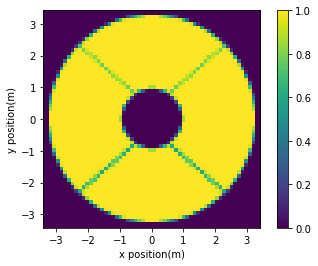

In [3]:
num_pupil_pixels = 60
pupil_grid_diameter = 60/56 * telescope_diameter
pupil_grid = make_pupil_grid(num_pupil_pixels, pupil_grid_diameter)

pwfs_grid = make_pupil_grid(120, 2 * pupil_grid_diameter)

magellan_aperture = evaluate_supersampled(make_magellan_aperture(), pupil_grid, 6)

imshow_field(magellan_aperture)
plt.xlabel('x position(m)')
plt.ylabel('y position(m)')
plt.colorbar()
plt.show()

Let's make our deformable mirror. MagAO-X uses a 2k-MEMS DM of Boston Micromachines. The influence functions of the DM are nearly gaussian. We will therefore make a DM with Gaussian influence functions. There are 50 actuators across the pupil. But for speed purposes we will limit the number of actuators to 10 across the pupil.

In [4]:
num_actuators_across_pupil = 10
actuator_spacing = telescope_diameter / num_actuators_across_pupil
influence_functions = make_gaussian_influence_functions(pupil_grid, num_actuators_across_pupil, actuator_spacing)
deformable_mirror = DeformableMirror(influence_functions)
num_modes = deformable_mirror.num_actuators


In [6]:
pupil_grid_diameter

6.964285714285714

Now we are going to make the optics of the pyramid wavefront sensor and the camera. Because the OCAM2K is a very high performance EMCCD we will simulate this detector as a noiseless detector.

In [7]:
pwfs = PyramidWavefrontSensorOptics(pupil_grid, pwfs_grid, separation=pupil_grid_diameter, pupil_diameter=telescope_diameter, wavelength_0=wavelength_wfs, q=3)
camera = NoiselessDetector(pwfs_grid)

TypeError: __init__() got multiple values for argument 'separation'

We are going to use a linear reconstruction algorithm for the wavefront estimation and for that we will need to measure the reference response of a perfect incoming wavefront. To create this we create an unabberated wavefront and propagate it through the pyramid wavefront sensor. Then we will integrate the response with our camera.

The final reference will be divided by the total sum to normalize the wavefront sensor response. Doing this consequently for all exposures will make sure that we can use this reference for arbitrary exposure times and photon fluxes.

In [ ]:
wf = Wavefront(magellan_aperture, wavelength_wfs)
wf.total_power = 1

camera.integrate(pwfs.forward(wf), 1)

image_ref = camera.read_out()
image_ref /= image_ref.sum()

imshow_field(image_ref)
plt.colorbar()
plt.show()

For the linear reconstructor we need to now the interaction matrix, which tells us how the pyramid wavefront sensor responds to each actuator of the deformable mirror. This can be build by sequentially applying a positive and negative voltage on a single actuator. The difference between the two gives us the actuator response.

We will use the full image of the pyramid wavefront sensor for the reconstruction, so we do not compute the normalized differences between the pupils.

In [ ]:
# Create the interaction matrix
probe_amp = 0.01 * wavelength_wfs
slopes = []

wf = Wavefront(magellan_aperture, wavelength_wfs)
wf.total_power = 1

for ind in range(num_modes):
    if ind % 10 == 0:
        print("Measure response to mode {:d} / {:d}".format(ind+1, num_modes))
    slope = 0

    # Probe the phase response
    for s in [1, -1]:
        amp = np.zeros((num_modes,))
        amp[ind] = s * probe_amp
        deformable_mirror.actuators = amp

        dm_wf = deformable_mirror.forward(wf)
        wfs_wf = pwfs.forward(dm_wf)

        camera.integrate(wfs_wf, 1)
        image = camera.read_out()
        image /= np.sum(image)

        slope += s * (image-image_ref)/(2 * probe_amp)

    slopes.append(slope)

slopes = ModeBasis(slopes)

The matrix that we build by poking the actuators can be used to transform a DM pattern into the wavefront sensor response. For wavefront reconstruction we want to invert this. We currently have,

$$\vec{S} = A\vec{\phi}.$$

With $\vec{S}$ being the response of the wavefront sensor, $A$ the interaction matrix and $\vec{\phi}$ the incoming pertubation on the DM. This equation can be solved in a linear least squares sense,

$$\vec{\phi} = \left(A^TA\right)^{-1} A^T\vec{S}.$$

The matrix $\left(A^TA\right)^{-1} A^T$ can be found by applying a pseudo-inverse operation on the matrix $A$. A regularized version of this is implemented in HCIpy with the inverse_tikhonov function.

In [ ]:
rcond = 1E-3
reconstruction_matrix = inverse_tikhonov(slopes.transformation_matrix, rcond=rcond, svd=None)

Initialize our wavefront and setup the propagator for evaluation of the PSF.

In [ ]:
spatial_resolution = wavelength_wfs / telescope_diameter
focal_grid = make_focal_grid(q=8, num_airy=20, spatial_resolution=spatial_resolution)
prop = FraunhoferPropagator(pupil_grid, focal_grid)
norm = prop(wf).power.max()

To have something to measure and correct we put a random shape on the DM.

In [ ]:
deformable_mirror.random(0.2 * wavelength_wfs)

Now lets setup the parameters of our AO system. The first step is to choose an integration time for the exposures. We choose an exposure time of 1 ms, so we are running our AO system at 1 kHz. For the controller we choose to use a leaky integrator which has been proven to be a robust controller. The leaky integrator has two parameters, the leakage and the gain.

In [ ]:
delta_t = 1E-3
leakage = 0.0
gain = 0.5

Let's check the current PSF that is created by the deformed mirror.

In [ ]:
PSF_in = prop(deformable_mirror.forward(wf)).power

imshow_psf(PSF_in / norm, vmax=1, vmin=1e-5, spatial_resolution=spatial_resolution)
plt.show()

Now we are ready to run the system in closed loop.

In [ ]:
def create_closed_loop_animation():
    
    PSF = prop(deformable_mirror(wf)).power
    
    fig = plt.figure(figsize=(14,3))
    plt.subplot(1,3,1)
    plt.title(r'DM surface shape ($\mathrm{\mu}$m)')
    im1 = imshow_field(deformable_mirror.surface/(1e-6), vmin=-1, vmax=1, cmap='bwr')
    plt.colorbar()    
    
    plt.subplot(1,3,2)
    plt.title('Wavefront sensor output')
    im2 = imshow_field(image_ref, pwfs_grid)
    plt.colorbar()
    
    plt.subplot(1,3,3)
    plt.title('Science image plane')
    im3 = imshow_field(np.log10(PSF / norm), vmax=0, vmin=-5, cmap='inferno')
    plt.colorbar()

    plt.close(fig)
    
    def animate(t):
        wf_dm = deformable_mirror.forward(wf)
        wf_pyr = pwfs.forward(wf_dm)

        camera.integrate(wf_pyr, 1)
        wfs_image = camera.read_out().astype('float')
        wfs_image /= np.sum(wfs_image)

        diff_image = wfs_image - image_ref
        deformable_mirror.actuators = (1-leakage) * deformable_mirror.actuators - gain * reconstruction_matrix.dot(diff_image)

        phase = magellan_aperture * deformable_mirror.surface
        phase -= np.mean(phase[magellan_aperture>0])
        
        psf = prop(deformable_mirror(wf) ).power
        
        im1.set_data(*pupil_grid.separated_coords, (magellan_aperture * deformable_mirror.surface).shaped / 1e-6)
        im2.set_data(*pwfs_grid.separated_coords, wfs_image.shaped)
        im3.set_data(*focal_grid.separated_coords, np.log10(psf.shaped / norm))

        return [im1, im2, im3]
    
    num_time_steps=21
    time_steps = np.arange(num_time_steps)
    anim = animation.FuncAnimation(fig, animate, time_steps, interval=160, blit=True)
    return HTML(anim.to_jshtml(default_mode='loop'))
    
create_closed_loop_animation()